# Algorithm Comparison Using Leave One Group Out Cross Validation

## Imported modules and custom functions

In [318]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score
from IPython.display import Image
from IPython.core.display import HTML 

def compare_algorithms(models, X, y, groups, scoring = 'roc_auc', balanced = 'false'):
    """
    Get scoring results for a set of models on the same set of data

    Parameters
    ----------
    models : list of tuples containing a classifier label and corresponding 
        classifier object which implements the "fit" and "predict_proba" methods

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    
    y : array-like, shape (n_samples) 
        Class vector corresponding to x.
    
    groups : array-like shape (n_samples)
        Vector describing the group for training examples in X. Used for 
        leave one group out cross-validation.
    
    scoring (optional : string
        Specifies the scorer object for evaluating the models.
    
    balanced (optional) : boolean 
        If given a 'true' value, training data is balanced before training.
        In either case models are evaluated on unbalanced test data.
        
    Return
    ------
    result_df : pandas dataframe shape (n_groups, 2)
        Returns the scores and corresponding model label for each LOGO validation.
    """
    results = []
    names = []
    for name, model in models:
        if(balanced == 'true'):
            # If balancing data, training and testing are coded seperately in order to still test on unbalanced data
            cv_results = []
            inds = logo.split(X, y, groups= groups)
            for train, test in inds:
                ytrain = [y[i] for i in train] # indexing list using a list
                ytest = [y[i] for i in test]
                us = RandomUnderSampler()
                ux, uy = us.fit_sample(X[train], ytrain)
                model.fit(ux, uy)
                if(scoring == 'roc_auc'):
                    y_score = model.predict_proba(X[test]) 
                    cv_results.append(roc_auc_score(ytest, y_score[:,1])) # y_score[:,1] holds probility of true class
                else:
                    cv_results.append(model.score(X[test], ytest))
            
            cv_results = np.array(cv_results)
            results.append(cv_results)
            names.append(name)
        else:
            cv_results = cross_val_score(model, X, y, groups=groups, scoring=scoring, cv=LeaveOneGroupOut())
            results.append(cv_results)
            names.append(name)
            
    result_df = pd.DataFrame(columns = [scoring, 'classifier'])
    for i in range(len(names)):
        result_df = pd.concat([result_df, pd.DataFrame({scoring: results[i], 'classifier': [names[i]] * 9})], axis = 0) 
    
    return result_df
    
def plot_comparison(results, group_names, scoring = 'roc_auc'):
    """
    Plot boxplots of model comparison results, and display summary of stats
    
    Parameters
    ----------
    results : pandas dataframe shape (n_groups, 2)
        scores and label names returned from @compare_algorithms
    
    group_names : list shape (n_groups)
        groups used in cross-validation
        
    scoring (optional : string
        Specifies the scorer object for evaluating the models.
    
    Return
    ------
    stat_summary : Styled dataframe summarising stats
    """
    group_names = sorted(group_names) # LeaveOneGroup out evaluates groups in sorted order
    model_names = results['classifier'].unique()
    stat_summary = pd.DataFrame(columns = ['Classifier', 'Mean', 'Std', 'Best', 'Worst'])
    for name in model_names:
        cv_results = results.loc[results['classifier'] == name].loc[:,scoring] 
        stat_summary = stat_summary.append({'Classifier': name, 'Mean': cv_results.mean(), 'Std': cv_results.std(), 
                              'Best': '%f (%s)'%(cv_results.max(), group_names[cv_results.argmax()]),
                              'Worst': '%f (%s)'%(cv_results.min(), group_names[cv_results.argmin()])}, ignore_index = 'true')
    sb.boxplot(x='classifier', y=scoring, data=results)
    sb.stripplot(x='classifier', y=scoring, data=results, jitter=True, color='white')
    return stat_summary.style.apply(highlight_max, subset =['Mean', 'Best']).apply(highlight_min, subset=['Std', 'Worst'])
        

# Datafram styling functions:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the minimum in a Series blue.
    '''
    is_max = s == s.min()
    return ['background-color: teal' if v else '' for v in is_max]

In [347]:
def overall_summary(all_results):
    stat_summary = pd.DataFrame(columns = ['Classifier', 'Scoring', 'Balanced', 'Mean', 'Std', 'Best', 'Worst'])
    for results, model_names, scoring, balanced in all_results:
        for name in model_names:
            cv_results = results.loc[results['classifier'] == name].select_dtypes(include=['number']).iloc[:,0]
            stat_summary = stat_summary.append({'Classifier': name, 'Scoring': scoring, 'Balanced': balanced, 'Mean': cv_results.mean(), 
                                                'Std': cv_results.std(), 'Best': '%f (%s)'%(cv_results.max(), group_names[cv_results.argmax()]),
                                                'Worst': '%f (%s)'%(cv_results.min(), group_names[cv_results.argmin()])}, ignore_index = 'true')
    return stat_summary.style.apply(highlight_max, subset =['Mean', 'Best']).apply(highlight_min, subset=['Std', 'Worst'])

## Training on unbalanced data and evaluating on accuracy

Load in the data then get group names for cross validation and define the columns of the feature space. Define each model and get comparison results.

In [322]:
hali_data = pd.read_csv('hali-class-data.csv')
group_names = hali_data['group'].unique()
features = [0,1,2]

models = []
# KNN model
knnModel = Pipeline([('standardize', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=51, n_jobs=4))])
models.append(('KNN', knnModel))
# LDA Model
models.append(('LDA', LinearDiscriminantAnalysis()))
# QDA Model
models.append(('QDA', QuadraticDiscriminantAnalysis()))
# NB Model
models.append(('NB', GaussianNB()))

X = hali_data.iloc[:,features].values
y = list(hali_data['class'].values)
groups = hali_data['group'].values

results_unbalanced_acc = compare_algorithms(models, X, y, groups, scoring = 'accuracy')

The results are summarized in a table and plotted over a boxplot. The highest and lowest values for columns are highlighted. Each white point is an accuracy from leaving one subject out, and are jittered to make it easier to see where each point lies. An imaging describing boxplots is shown below. 

![Image](http://itknowledgeexchange.techtarget.com/writing-for-business/files/2012/12/box-plot.png)

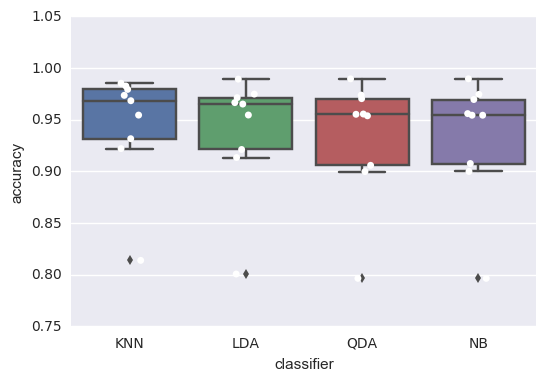

In [325]:
plot_comparison(results_unbalanced_acc, group_names, scoring = 'accuracy')

## Training on unbalanced data and scoring using auc

Using the same data and models now evaluating models using auc.

In [326]:
scoring = 'roc_auc'
# auc scoring requires integer classes
hali_data.loc[hali_data['class'] == 'Non-Cancer', 'class'] = 0
hali_data.loc[hali_data['class'] == 'Cancer', 'class'] = 1

X = hali_data.iloc[:,features].values
y = list(hali_data['class'].values)
groups = hali_data['group'].values

results_unbalanced_auc = compare_algorithms(models, X, y, groups, scoring=scoring) # Same models and data, scored on auc metric

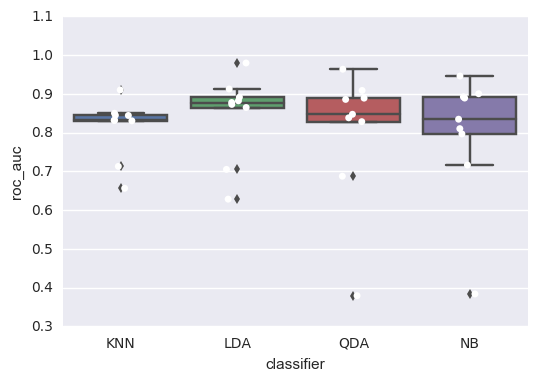

In [327]:
plot_comparison(results_unbalanced_auc, group_names, scoring=scoring)

## Training on balanced, testing on unbalanced, and scoring using auc

For training using balanced data we use a random undersampling algorithm. The models are trained using a balanced subset (n = 2*n_cancer_sample) of the entire set excluding one subject at a time, it is then tested on a subject with no balancing. For consistent results we train and test the models each 5 times using different undersampled data sets with every iteration. 

In [328]:
knnModel = Pipeline([('standardize', StandardScaler()), ('classifier', KNeighborsClassifier(n_neighbors=201, n_jobs=4))])
models[0] = ('KNN', knnModel)
all_scores = []
for random_undersampling in range(5):
    all_scores.append(compare_algorithms(models, X, y, groups, balanced='true'))

mean_undersampled = all_scores[0][scoring]
for random_undersampling in range(1,5):
    mean_undersampled = mean_undersampled + all_scores[random_undersampling][scoring]
results_balanced_auc = all_scores[0]
results_balanced_auc[scoring] = mean_undersampled/5

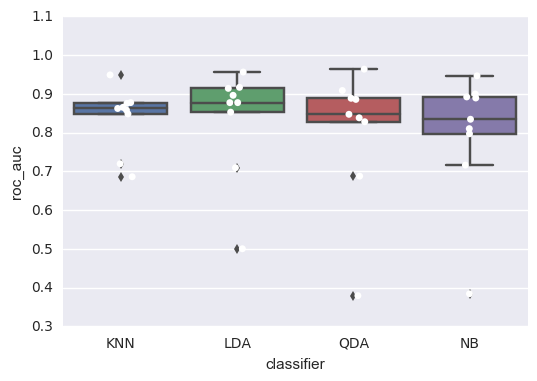

In [329]:
plot_comparison(results_balanced_auc, group_names, scoring=scoring)

## Training on balanced, testing on unbalanced, and scoring using accuracy

For completeness we get the accuracy results of training using randomly undersampled datasets.

In [312]:
scoring = 'accuracy'
all_scores = []
for random_undersampling in range(5):
    all_scores.append(compare_algorithms(models, X, y, groups, scoring='accuracy', balanced='true'))

mean_undersampled = all_scores[0][scoring]
for random_undersampling in range(1,5):
    mean_undersampled = mean_undersampled + all_scores[random_undersampling][scoring]
results_balanced_acc = all_scores[0]
results_balanced_acc[scoring] = mean_undersampled/5

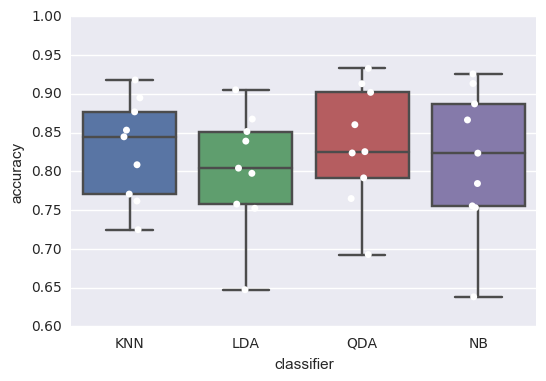

In [313]:
plot_comparison(results_balanced_acc, group_names, scoring=scoring)

## Summary of Results

LDA and KNN constantly perform best so we summarize only those results.

In [355]:
models = ['KNN', 'LDA']
all_results_auc = []
all_results_acc = []
all_results_auc.append((results_unbalanced_auc, models,'roc_auc', False))
all_results_auc.append((results_balanced_auc, models, 'roc_auc', True))
all_results_acc.append((results_unbalanced_acc, models, 'accuracy', False)) 
all_results_acc.append((results_balanced_acc, models, 'accuracy', True))

Results are summarized in the tables below. LDA trained using unbalanced data has the best overall auc with 84.6, while the most consistent model is KNN (unbalanced) with a standard deviation of 7.8%. For both balanced and unbalanced training LDA has a significantly higher standard deviation over AUC. The KNN model trained with balanced data performs the best when faced with the worst subject, with the second best mean auc (-0.7 percent from unbalanced LDA) and second best std dev (-0.5 percent from unbalanced KNN).

The accuracy numbers are much higher as is expected where the number of non-cancerous pixels is much higher and presents an easier classification. This if further confirmed when we see much lower accuracies from balancing the data before testing based on accuracy.

A few interesting points are that 
* KNN performs better on auc when balancing the training data 
* The worst subject is different in roc_auc than both accuracy with balanced and unbalanced data 
* The best subject is the same accross all other than accuracy on balanced data

In [356]:
overall_summary(all_results_auc)

In [357]:
overall_summary(all_results_acc)

In [358]:
results_unbalanced_auc

,classifier,roc_auc
0,KNN,0.831530
1,KNN,0.844235
2,KNN,0.910151
3,KNN,0.844820
4,KNN,0.849887
5,KNN,0.656231
6,KNN,0.712849
7,KNN,0.831852
8,KNN,0.830369
0,LDA,0.872768


In [359]:
group_names

array(['S15', 'S25', 'S26', 'S38', 'S39', 'S48', 'S5', 'S52', 'S58'], dtype=object)